In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder as LE
import string
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from gensim import utils
import gensim.parsing.preprocessing as gsp
%matplotlib inline

In [3]:
NONAVIATION_PATH = "nadb.xlsx"
AVIATION_PATH = "adb.xlsx"

nadf = pd.read_excel(NONAVIATION_PATH, sheet_name=1)
adf = pd.read_excel(AVIATION_PATH,sheet_name=1)

In [4]:
df1 = nadf.copy()
col = df1.columns.to_list()

#traint1 = np.array([datetime.strptime(d, '%m/%d/%y') for d in df1[col[17]]])
traint1 = np.array([datetime.strptime(str(d), "%Y-%m-%d %H:%M:%S" ) for d in df1[col[17]]])
traint2 = traint1 - max(traint1)
traint3 = -np.array([t.days for t in traint2])
df1[col[17]] = traint3.astype(float)
df1 = df1.assign(emonth = np.array([t.month for t in traint1]))
df1 = df1.assign(eweek = np.array([t.weekday() for t in traint1]))
df1 = df1.assign(ehr = np.array([t.hour for t in traint1]))
df1 = df1.assign(emin = np.array([t.minute for t in traint1]))


#select columns and drop missing data and duplicates
df1 = df1[[col[1]]+col[6:14] + col[17:20]+[col[21]] + col[23:]]
df1 = df1[df1['INJ_CLASSN_C'].notna()]
df1 = df1[df1['AREA_C'].notna()]
df1 = df1.drop_duplicates()

df1['SEX_C'].fillna('M', inplace=True) #replace missing sex with M 
df1['AGE'].fillna(22, inplace=True) #replace missing age with median age
df1['PAYGRADE'].fillna(4, inplace = True) #replace missing paygrade with median age
df1["PCN_C"][df1["PCN_C"].isna()] = 'MS-05-00' #most common occuring 
df1["PCN_C"]=df1["PCN_C"].str[:2]#.split('-')

cats = ['A', 'B', 'C', 'D','E','F','G','H']
for i in range(len(cats)):
    df1[col[8]] = df1[col[8]].replace(cats[i], i)
    
cats = ['A', 'B', 'C', 'D','E','F','G','H']
for i in range(len(cats)):
    df1[col[21]] = df1[col[21]].replace(cats[i], i)
    
    
#paygrade    
cats = ["UNK","MIDN","E01","E02","E03","E04","E05","E06","E07","E08","E09","O01","O02","W02","O03","W04","O04","W05","O05","O06","GS12"]
for i in range(len(cats)):
    df1[col[1]] = df1[col[1]].replace(cats[i], i)
    
cats = ['M','F']
for i in range(len(cats)):
    df1['SEX_C'] = df1['SEX_C'].replace(cats[i], i)
    
cats = ['CV','CVN']
for i in range(len(cats)):
    df1['VESL_TYPE'] = df1['VESL_TYPE'].replace(cats[i], i)
    

df2 = df1.copy()
counts = df2['AREA'].value_counts()
idx = counts[counts.lt(10)].index
df2.loc[df2['AREA'].isin(idx), 'AREA'] = 'Others'
df1 = df2

df1 = df1.drop_duplicates()

#compressing into 3 classes
a = np.array(df1["INJ_CLASSN_C"].values.tolist())
a = np.where(a < 4, 0, a)
a = np.where(a == 4, 1, a)
a = np.where(a > 4, 2, a)
df1["INJ_CLASSN_C"] = a.tolist()

#carrier name cleanup and replacing them with dates
cleanup_nums = {"ACTY_NAME_LONG": {
                                     "USS HARRY S TRUMAN (CVN -75)" : "TRUMAN",
"USS RONALD REAGAN  (CVN-76)"  : "REAGAN",
"USS JOHN C STENNIS (CVN-74)"  : "STENNIS",
"USS DWIGHT D EISENHOWER (CVN-69)" : "EISENHOWER",
"USS NIMITZ  (CVN 68)" : "NIMITZ",
"USS GEORGE H W BUSH (CVN-77)" : "BUSH",
"USS ENTERPRISE"  : "ENTERPRISE",
"USS GEORGE WASHINGTON (CVN-73)" : "WASHINGTON",
"USS THEODORE ROOSEVELT" : "ROOSEVELT",
"USS ABRAHAM LINCOLN"  : "LINCOLN",
"GEORGE WASHINGTON"  : "WASHINGTON",
"USS THEODORE ROOSEVELT  (CVN-71)" : "ROOSEVELT",
"USS CARL VINSON  (CVN-70)" : "VINSON",
"USS ABRAHAM LINCOLN (CVN-72)" : "LINCOLN",
"USS JOHN F KENNEDY" : "KENNEDY",
"NIMITZ"  : "NIMITZ",
"RONALD REAGAN"   : "REAGAN",
"ABRAHAM LINCOLN" : "LINCOLN",
"JOHN C STENNIS"  : "STENNIS",
"USS GERALD R FORD (CVN 78)" : "FORD",
"CARL VINSON" : "VINSON",
"CVN 78 GERALD R FORD PCU" : "FORD",
"KITTY HAWK" : "HAWK",
"ENTERPRISE" : "ENTERPRISE",
"USS ENTERPRISE (CVN 65)" : "ENTERPRISE"}}
df1.replace(cleanup_nums, inplace=True)

df1['actycommissioned'] = df1['ACTY_NAME_LONG']
df1['actydecommissioned'] = df1['ACTY_NAME_LONG']

netcat = { "actycommissioned" : {'TRUMAN'  :1998,
'REAGAN'  :2003,
'STENNIS' :1995,
'NIMITZ'     : 1975,
'EISENHOWER' : 1977,
'WASHINGTON' : 1992,
'ROOSEVELT'   : 1986,
'BUSH'     :2009,
'LINCOLN'  : 1989,
'ENTERPRISE'  : 1961,
'VINSON'   :1982,
'KENNEDY'   :1968,
'FORD'  : 2017,
'HAWK'     : 1961}, 
          "actydecommissioned" : {'TRUMAN'  :2020,
'REAGAN'  :2020,
'STENNIS' :2020,
'NIMITZ'     : 2020,
'EISENHOWER' : 2020,
'WASHINGTON' : 2020,
'ROOSEVELT'   : 2020,
'BUSH'     :2020,
'LINCOLN'  : 2020,
'ENTERPRISE'  : 2017,
'VINSON'   :2020,
'KENNEDY'   :2007,
'FORD'  : 2020,
'HAWK'     : 2009}
         }
df1.replace(netcat, inplace=True)

#clean text
filters = [
           gsp.strip_tags, 
           gsp.strip_punctuation,
           gsp.strip_multiple_whitespaces,
           gsp.strip_numeric,
           gsp.remove_stopwords, 
           gsp.strip_short, 
           gsp.stem_text
          ]

def clean_text(s):
    s = s.lower()
    s = utils.to_unicode(s)
    for f in filters:
        s = f(s)
    return s

df1['BRIEF_NARR'] = df1.apply(lambda row: clean_text(row['BRIEF_NARR']), axis=1)


#onehot encode with dummy columns
df1 = pd.get_dummies(df1, 
               prefix = ['PCN_C','AREA'], 
               columns = ['PCN_C','AREA'], 
               drop_first=True, dtype = int) 

# remove
df1.drop(['AREA_C','PCN_NAME','INJ_CLASSN', 'ACTY_NAME_LONG'],axis=1,inplace= True)


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6963 entries, 0 to 7324
Columns: 139 entries, PAYGRADE to AREA_X-DIVISION SPACE
dtypes: float64(2), int32(128), int64(8), object(1)
memory usage: 4.0+ MB


In [6]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn.base import BaseEstimator
from sklearn import utils as skl_utils
from tqdm import tqdm

import multiprocessing
import numpy as np

class Doc2VecTransformer(BaseEstimator):

    def __init__(self, vector_size=100, learning_rate=0.02, epochs=20):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self._model = None
        self.vector_size = vector_size
        self.workers = multiprocessing.cpu_count() - 1

    def fit(self, df_x, df_y=None):
        tagged_x = [TaggedDocument(clean_text(row).split(), [index]) for index, row in enumerate(df_x)]
        model = Doc2Vec(documents=tagged_x, vector_size=self.vector_size, workers=self.workers)

        for epoch in range(self.epochs):
            model.train(skl_utils.shuffle([x for x in tqdm(tagged_x)]), total_examples=len(tagged_x), epochs=1)
            model.alpha -= self.learning_rate
            model.min_alpha = model.alpha

        self._model = model
        return self

    def transform(self, df_x):
        return np.asmatrix(np.array([self._model.infer_vector(clean_text(row).split())
                                     for index, row in enumerate(df_x)]))

In [7]:
doc2vec_trf = Doc2VecTransformer()
doc2vec_features = doc2vec_trf.fit(df1['BRIEF_NARR']).transform(df1['BRIEF_NARR'])
doc2vec_features

100%|█████████████████████████████████████████████████████████████████████████| 6963/6963 [00:00<00:00, 3427407.43it/s]


matrix([[-5.2159481e-05,  4.0693344e-03,  1.0675314e-03, ...,
          3.8826726e-03,  4.5191711e-03, -3.1132731e-03],
        [-3.2099034e-03, -2.9430273e-03, -1.7769579e-03, ...,
         -6.8683084e-04, -1.7189748e-03, -2.8096600e-03],
        [ 4.4069514e-01, -4.6365592e-01,  3.0557001e-01, ...,
          1.9128144e-01,  3.7057221e-01,  2.4166147e-01],
        ...,
        [ 2.2505242e-03, -2.0229309e-03, -4.7452380e-03, ...,
         -4.5356469e-04, -7.7510887e-04, -2.5108953e-03],
        [ 1.7323645e-03, -1.3093521e-03,  1.8112066e-03, ...,
          6.4619270e-04, -3.8910077e-03,  3.5036283e-03],
        [-8.0875808e-04, -3.7410324e-03, -2.4648195e-03, ...,
          1.6443989e-03,  2.5419812e-03, -3.4346224e-03]], dtype=float32)

In [8]:
df2 = df1.copy().reset_index()
df2 = pd.concat([df2, pd.DataFrame(doc2vec_features)], axis=1)
df2.drop(['BRIEF_NARR','index'],axis=1,inplace= True)
df1 = df2.copy()

In [9]:
df1.head()

,PAYGRADE,INJ_CLASSN_C,AGE,SEX_C,EVENT_DATE_TIME,FY,EVENT_SEVTY_C,VESL_TYPE,actycommissioned,actydecommissioned,...,90,91,92,93,94,95,96,97,98,99
0,4,1,21.0,0,4848.0,2006,3,1,1992,2020,...,-0.001348,-0.004529,-0.002295,0.000640,0.002913,0.001050,-0.002137,0.003883,0.004519,-0.003113
1,5,1,26.0,0,4832.0,2006,3,1,1992,2020,...,-0.003759,-0.003776,-0.000260,0.001857,0.003945,-0.002614,0.004079,-0.000687,-0.001719,-0.002810
2,6,1,42.0,0,4680.0,2006,3,1,1977,2020,...,0.550586,-0.246457,0.303531,-0.504913,-0.066991,0.122270,-0.642104,0.191281,0.370572,0.241661
3,5,0,24.0,0,4965.0,2006,2,1,2003,2020,...,-0.003980,-0.004386,-0.001361,0.001807,-0.000121,-0.003526,0.004570,-0.001402,0.000219,0.000028
4,4,2,25.0,0,4957.0,2006,3,1,1986,2020,...,0.517864,-0.265420,0.324948,-0.486884,-0.061234,0.102836,-0.556184,0.180205,0.446046,0.203484


Class=1, n=3939 (33.333%)
Class=0, n=3939 (33.333%)
Class=2, n=3939 (33.333%)


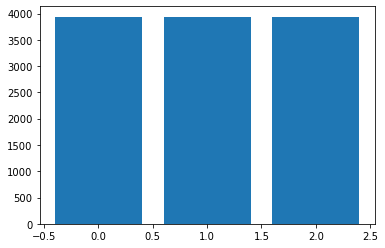

In [10]:
from pandas import read_csv
from imblearn.over_sampling import SMOTE
from collections import Counter

df2 = df1.copy()
df2.drop(['INJ_CLASSN_C'],axis=1,inplace= True)
X, y = df2, df1['INJ_CLASSN_C']
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [11]:
X

,PAYGRADE,AGE,SEX_C,EVENT_DATE_TIME,FY,EVENT_SEVTY_C,VESL_TYPE,actycommissioned,actydecommissioned,PCN_C_CE,...,90,91,92,93,94,95,96,97,98,99
0,4,21.000000,0,4848.000000,2006,3,1,1992,2020,0,...,-0.001348,-0.004529,-0.002295,0.000640,0.002913,0.001050,-0.002137,0.003883,0.004519,-0.003113
1,5,26.000000,0,4832.000000,2006,3,1,1992,2020,0,...,-0.003759,-0.003776,-0.000260,0.001857,0.003945,-0.002614,0.004079,-0.000687,-0.001719,-0.002810
2,6,42.000000,0,4680.000000,2006,3,1,1977,2020,0,...,0.550586,-0.246457,0.303531,-0.504913,-0.066991,0.122270,-0.642104,0.191281,0.370572,0.241661
3,5,24.000000,0,4965.000000,2006,2,1,2003,2020,0,...,-0.003980,-0.004386,-0.001361,0.001807,-0.000121,-0.003526,0.004570,-0.001402,0.000219,0.000028
4,4,25.000000,0,4957.000000,2006,3,1,1986,2020,0,...,0.517864,-0.265420,0.324948,-0.486884,-0.061234,0.102836,-0.556184,0.180205,0.446046,0.203484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11812,4,20.426050,0,3031.170420,2011,3,1,2008,2020,0,...,0.003760,-0.003448,-0.001784,-0.001267,-0.000138,0.004142,-0.003921,0.000260,-0.003085,0.000633
11813,5,26.509657,0,1559.567600,2015,3,1,1995,2020,0,...,0.000535,0.000960,-0.003030,-0.000241,0.001580,-0.001279,0.000589,0.000760,-0.001372,-0.002315
11814,5,28.276485,0,1738.000000,2015,3,1,1978,2020,0,...,0.263142,-0.102292,0.131082,-0.232669,-0.036001,0.060816,-0.312083,0.088371,0.153268,0.115121
11815,4,21.569749,0,2888.784875,2011,3,1,1961,2017,0,...,0.003694,0.004843,-0.002365,-0.000086,0.004148,0.000277,-0.004572,-0.000284,0.000236,-0.002115


In [12]:
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score


from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import xgboost as xgb
import time

In [13]:
#use xgboost with default parameters
xgbbasic = xgb.sklearn.XGBClassifier()

start = time.time()
results = cross_val_score(xgbbasic, X, y, cv=10)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for XGboost Classifier: Mean = 74.894%, STD = 10.73%
Execution time: 5.59 min


In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(xgbbasic, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)

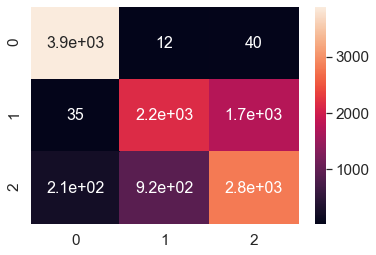

In [15]:
import seaborn as sn
df_cm = pd.DataFrame(conf_mat, range(3), range(3))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

Counter({1: 3939, 2: 1899, 0: 1125})
Counter({0: 1125, 1: 1125, 2: 1125})
Class=0, n=1125 (33.333%)
Class=1, n=1125 (33.333%)
Class=2, n=1125 (33.333%)


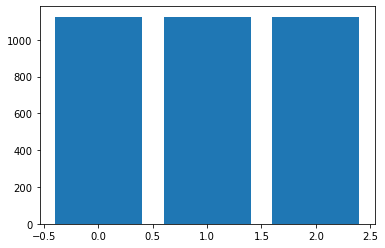

In [13]:
#undersampling
from imblearn.under_sampling import NearMiss
# define dataset
df2 = df1.copy()
df2.drop(['INJ_CLASSN_C'],axis=1,inplace= True)
X, y = df2, df1['INJ_CLASSN_C']
# summarize class distribution
counter = Counter(y)
print(counter)
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [14]:
#use xgboost with default parameters
xgbbasic = xgb.sklearn.XGBClassifier()

start = time.time()
results = cross_val_score(xgbbasic, X, y, cv=5)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

CV accuracy for XGboost Classifier: Mean = 79.022%, STD = 3.34%
Execution time: 0.79 min


In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(xgbbasic, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(conf_mat, range(3), range(3))
df_cm

,0,1,2
0,1071,29,25
1,9,865,251
2,44,269,812


Training accuracy: 0.8862222222222222


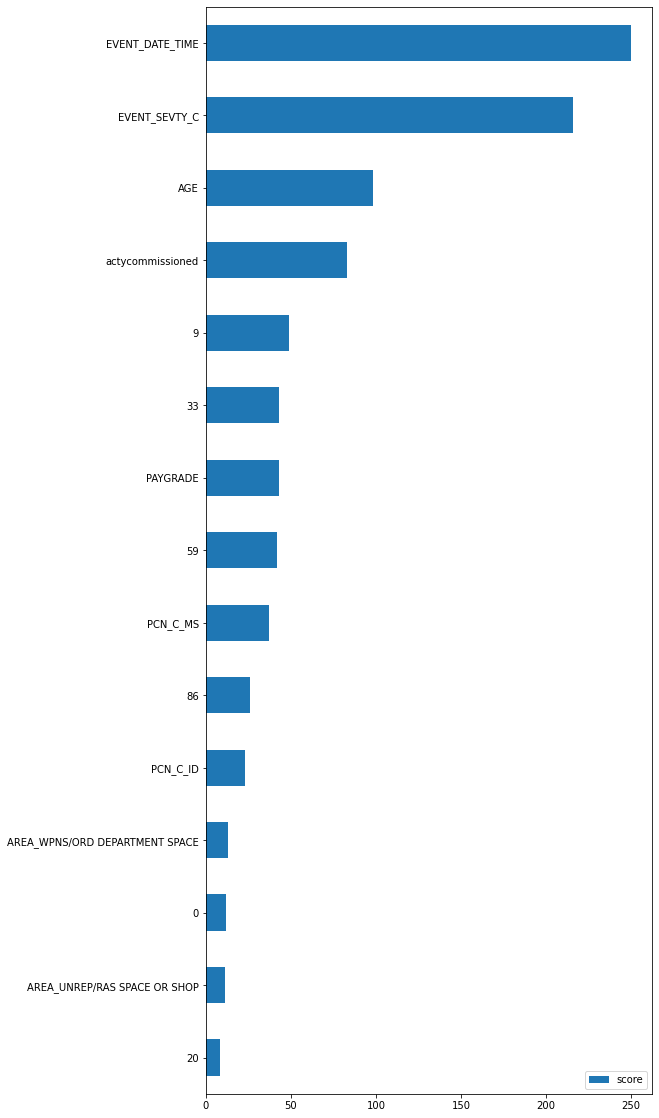

In [16]:
# plot feature importance
xgbbasic.fit(X,y)
preds = xgbbasic.predict(X)
print("Training accuracy:", accuracy_score(y, preds))
feature_important = xgbbasic.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values[:15], index=keys[:15], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize=(8,20))
plt.show()

Training accuracy: 0.8758518518518519


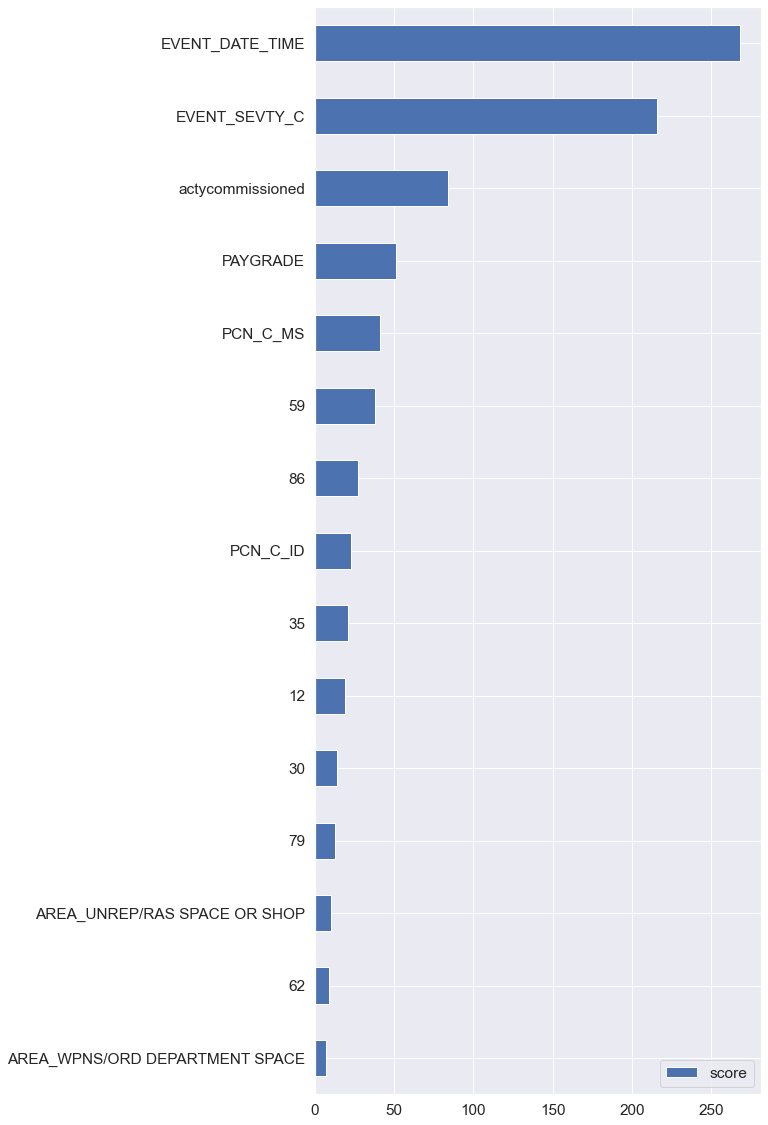

In [19]:
# plot feature importance
xgbbasic.fit(X,y)
preds = xgbbasic.predict(X)
print("Training accuracy:", accuracy_score(y, preds))
feature_important = xgbbasic.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values[:15], index=keys[:15], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize=(8,20))
plt.show()

## TF ID

In [42]:


from sklearn.feature_extraction.text import TfidfVectorizer

class Text2TfIdfTransformer(BaseEstimator):

    def __init__(self):
        self._model = TfidfVectorizer()
        pass

    def fit(self, df_x, df_y=None):
        df_x = df_x.apply(lambda x : clean_text(x))
        self._model.fit(df_x)
        return self

    def transform(self, df_x):
        return self._model.transform(df_x)

In [43]:
tfidf_transformer = Text2TfIdfTransformer()
tfidf_vectors = tfidf_transformer.fit(df1['BRIEF_NARR']).transform(df1['BRIEF_NARR'])

In [44]:
import scipy.sparse    
df2 = df1.copy().reset_index()
df2 = pd.concat([df2, pd.DataFrame.sparse.from_spmatrix(tfidf_vectors)], axis=1)
df2.drop(['BRIEF_NARR','index'],axis=1,inplace= True)
df1 = df2.copy()

Counter({1: 3939, 2: 1899, 0: 1125})


C:\Users\sayan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


Counter({0: 1125, 1: 1125, 2: 1125})
Class=0, n=1125 (33.333%)
Class=1, n=1125 (33.333%)
Class=2, n=1125 (33.333%)


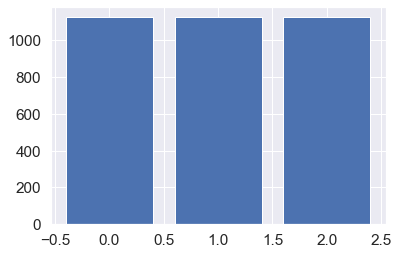

In [45]:
#undersampling
from imblearn.under_sampling import NearMiss
# define dataset
df2 = df1.copy()
df2.drop(['INJ_CLASSN_C'],axis=1,inplace= True)
X, y = df2, df1['INJ_CLASSN_C']
# summarize class distribution
counter = Counter(y)
print(counter)
# define the undersampling method
undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
X, y = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [46]:
#use xgboost with default parameters
xgbbasic = xgb.sklearn.XGBClassifier()

start = time.time()
results = cross_val_score(xgbbasic, X, y, cv=10)
end = time.time()
print("CV accuracy for XGboost Classifier: Mean = %.3f%%, STD = %.2f%%" % (results.mean()*100, results.std()*100))
print("Execution time: %.2f min" % ((end - start)/60))

C:\Users\sayan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\sayan\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\sayan\Anaconda3\lib\site-packages\xgboost\sklearn.py", line 726, in fit
    missing=self.missing, nthread=self.n_jobs)
  File "C:\Users\sayan\Anaconda3\lib\site-packages\xgboost\core.py", line 380, in __init__
    feature_types)
  File "C:\Users\sayan\Anaconda3\lib\site-packages\xgboost\core.py", line 239, in _maybe_pandas_data
    raise ValueError(msg + ', '.join(bad_fields))
TypeError: sequence item 0: expected str instance, int found

  FitFailedWarning)


CV accuracy for XGboost Classifier: Mean = nan%, STD = nan%
Execution time: 0.12 min


In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(xgbbasic, X, y, cv=10)
conf_mat = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(conf_mat, range(3), range(3))
df_cm

TypeError: sequence item 0: expected str instance, int found

In [50]:
# plot feature importance
xgbbasic.fit(X,y)
preds = xgbbasic.predict(X)
print("Training accuracy:", accuracy_score(y, preds))
feature_important = xgbbasic.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values[:15], index=keys[:15], columns=["score"]).sort_values(by = "score", ascending=True)
data.plot(kind='barh', figsize=(8,20))
plt.show()

TypeError: sequence item 0: expected str instance, int found

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3375 entries, 0 to 3374
Columns: 2371 entries, PAYGRADE to 2233
dtypes: Sparse[float64, 0.0](2234), float64(2), int32(128), int64(7)
memory usage: 2.1 MB
